样本数量为10000


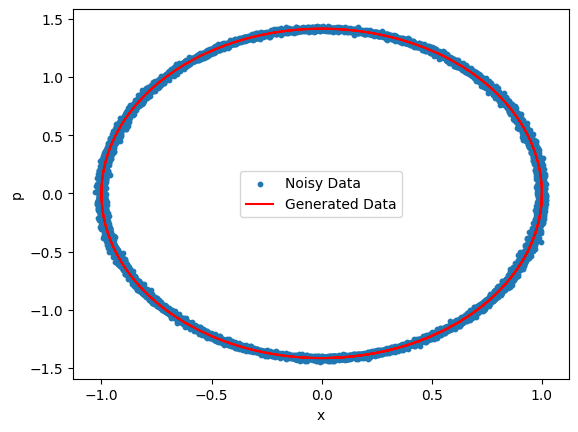

In [103]:
# 读取数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('harmonic_oscillator_trajectory.csv')
x_generated = data['x'].to_numpy()
y_generated = data['p'].to_numpy()
N = x_generated.shape[0]

# 数据添加噪声
np.random.seed(42)

noise1 = np.random.normal(0, 0.01, size=N)  
noise2 = np.random.normal(0, 0.01, size=N)  
x_m = x_generated + noise1
y_m = y_generated + noise2                       

print(f'样本数量为{N}')
# 可视化数据
plt.scatter(x_m, y_m, s=10, label="Noisy Data")
plt.plot(x_generated, y_generated, color='r', label="Generated Data")
plt.legend()

plt.xlabel("x")
plt.ylabel("p")
plt.show()

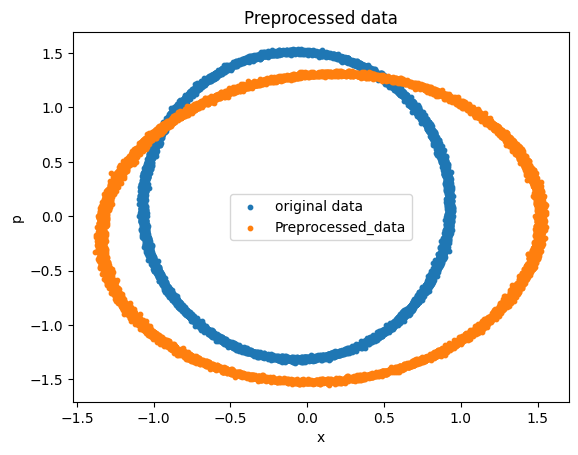

In [104]:
# 数据预处理

x = x_m - np.mean(x_m)
y = y_m - np.mean(y_m)

data = np.vstack((x,y)).T

cov = np.cov(data.T)

eigvalues,eigvector = np.linalg.eig(cov)

pca_data = np.dot(data, eigvector)
Preprocessed_data = np.dot(pca_data, np.diag(1.0 / np.sqrt(eigvalues)))


# 可视化数据
plt.scatter(data[:,0], data[:,1], s=10, label="original data")
plt.scatter(Preprocessed_data[:,0], Preprocessed_data[:,1], s=10, label="Preprocessed_data")

plt.legend()
plt.title("Preprocessed data")
plt.xlabel("x")
plt.ylabel("p")
plt.show()



In [179]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 将数据分为两部分，一半为训练集一半为测试集
x_t = Preprocessed_data[:,0][::2]
y_t = Preprocessed_data[:,1][::2]
x_v = Preprocessed_data[:,0][1::2]
y_v = Preprocessed_data[:,1][1::2]

# 参数设定
L = 0.1  # 可调的标量，控制噪声的强度

# 生成协方差矩阵
cov_noise = L * np.eye(2)  # 2维协方差矩阵，L是标量

# 生成高斯噪声
noise = np.random.multivariate_normal([0, 0], cov_noise, size=x_t.shape[0]*2)

# 为训练集添加噪声
x_t_noisy = x_t + noise[::2, 0]
y_t_noisy = y_t + noise[::2, 1]
x_v_noisy = x_v + noise[1::2, 0]
y_v_noisy = y_v + noise[1::2, 1]



train_data = torch.tensor(np.vstack((x_t_noisy,y_t_noisy)).T, dtype=torch.float32)
train_target_data = torch.tensor(np.vstack((x_t,y_t)).T, dtype=torch.float32)

val_data = torch.tensor(np.vstack((x_v_noisy,y_v_noisy)).T, dtype=torch.float32)
val_target_data = torch.tensor(np.vstack((x_v_noisy,y_v_noisy)).T, dtype=torch.float32)

train_dataset = TensorDataset(train_data, train_target_data)
val_dataset = TensorDataset(val_data, val_target_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 定义神经网络
class LocalMC(nn.Module):
    def __init__(self):
        super(LocalMC, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # 输入层到隐藏层
        self.fc2 = nn.Linear(64, 64)  # 隐藏层
        self.fc3 = nn.Linear(64, 2)   # 隐藏层到输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU激活函数
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一层没有激活函数，输出为原始数据
        return x

# 初始化模型
model = LocalMC()

# 损失函数和优化器
criterion = nn.MSELoss()  # 对于回归问题，通常使用均方误差（MSE）损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练神经网络
num_epochs = 1000  # 训练的轮次
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    running_loss = 0.0

    # 训练阶段
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 清除梯度
        outputs = model(inputs)  # 前向传播
        loss = criterion(outputs, targets)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item()   
    
    # 在每个 epoch 结束后计算训练损失
    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    
    # 验证阶段
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0
    with torch.no_grad():  # 禁用梯度计算
        for inputs, targets in val_loader:
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, targets)  # 计算损失
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [1/1000], Train Loss: 0.1676, Validation Loss: 0.0169
Epoch [2/1000], Train Loss: 0.0632, Validation Loss: 0.0296
Epoch [3/1000], Train Loss: 0.0570, Validation Loss: 0.0407
Epoch [4/1000], Train Loss: 0.0555, Validation Loss: 0.0444
Epoch [5/1000], Train Loss: 0.0552, Validation Loss: 0.0460
Epoch [6/1000], Train Loss: 0.0552, Validation Loss: 0.0461
Epoch [7/1000], Train Loss: 0.0551, Validation Loss: 0.0449
Epoch [8/1000], Train Loss: 0.0548, Validation Loss: 0.0482
Epoch [9/1000], Train Loss: 0.0546, Validation Loss: 0.0481
Epoch [10/1000], Train Loss: 0.0549, Validation Loss: 0.0478
Epoch [11/1000], Train Loss: 0.0546, Validation Loss: 0.0485
Epoch [12/1000], Train Loss: 0.0549, Validation Loss: 0.0470
Epoch [13/1000], Train Loss: 0.0545, Validation Loss: 0.0494
Epoch [14/1000], Train Loss: 0.0548, Validation Loss: 0.0495
Epoch [15/1000], Train Loss: 0.0551, Validation Loss: 0.0484
Epoch [16/1000], Train Loss: 0.0552, Validation Loss: 0.0482
Epoch [17/1000], Train Loss: 0.05

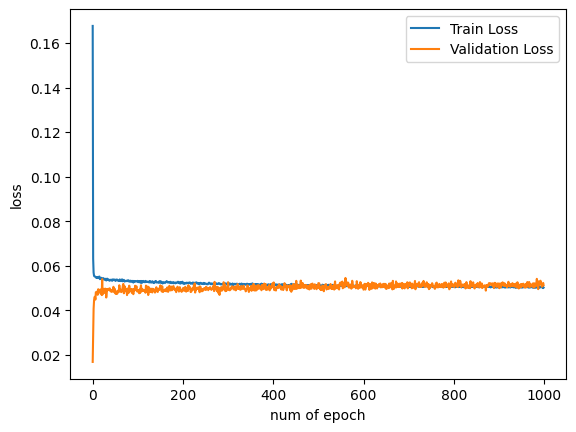

In [180]:
plt.plot(np.arange(num_epochs),train_loss_list,label = "Train Loss")
plt.plot(np.arange(num_epochs),val_loss_list,label = "Validation Loss")
plt.legend()
plt.xlabel('num of epoch')
plt.ylabel('loss')

plt.show()

In [195]:
# 总体展示神经网络效果
noisy_Preprocessed_data = Preprocessed_data + noise
Preprocessed_data_tensor = torch.tensor(Preprocessed_data,dtype=torch.float32)
noisy_Preprocessed_data_tensor = torch.tensor(noisy_Preprocessed_data,dtype=torch.float32)

with torch.no_grad():
    denoised_data = model(noisy_Preprocessed_data_tensor).numpy()


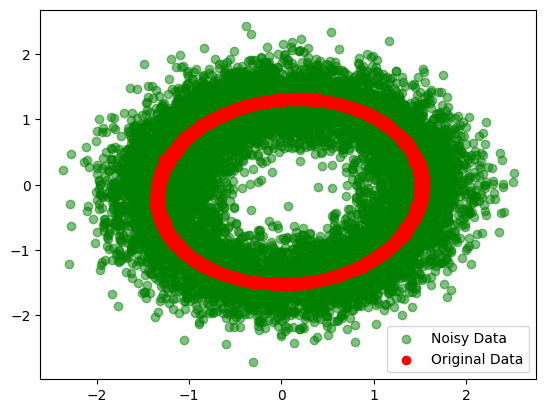

In [207]:
plt.scatter(noisy_Preprocessed_data[:,0],noisy_Preprocessed_data[:,1],label = "Noisy Data",alpha=0.5,color = 'green')
plt.scatter(Preprocessed_data[:,0],Preprocessed_data[:,1],label = "Original Data",color = 'red')
plt.legend()
plt.show()

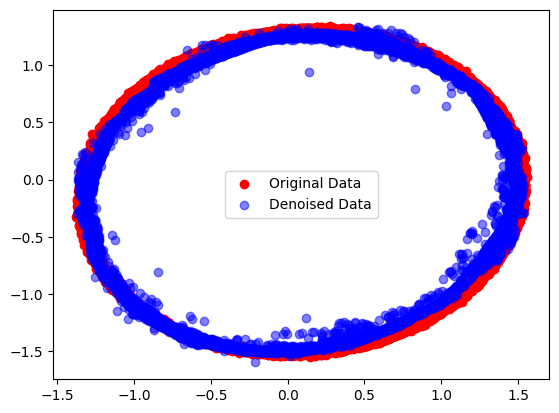

In [203]:
plt.scatter(Preprocessed_data[:,0],Preprocessed_data[:,1],label = "Original Data",color = 'red')
plt.scatter(denoised_data[:,0],denoised_data[:,1],label = "Denoised Data",color = 'blue',alpha=0.5)

plt.legend()
plt.show()

9458


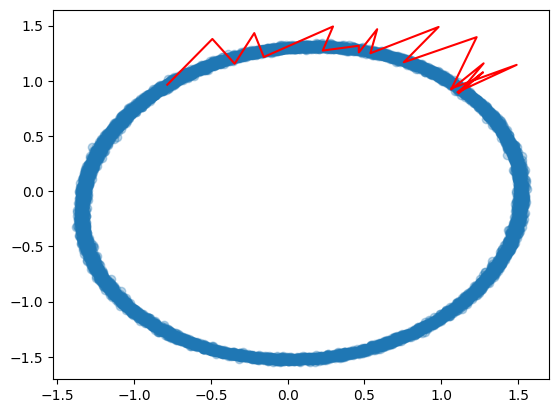

In [230]:
# 测试模型，输入加噪数据并输出去噪结果
model.eval()  # 设置为评估模式

step_num = 10 #walk and pull 次数
random_value = np.random.randint(0, N+1)
print(random_value)
L = 0.5

x_LMC,y_LMC = Preprocessed_data[random_value,0],Preprocessed_data[random_value,1]
x_LMC_list = [x_LMC]
y_LMC_list = [y_LMC]

for i in range(step_num):
    #walk
    x_LMC += np.random.uniform(0,L)
    y_LMC += np.random.uniform(0,L)
    
    x_LMC_list.append(x_LMC)
    y_LMC_list.append(y_LMC)

    point = np.array([[x_LMC,y_LMC]])
    
    #pull
    point_tensor = torch.tensor(point, dtype=torch.float32)
    with torch.no_grad():
        pull = model(point_tensor)
    x_LMC = pull[0][0].item()
    y_LMC = pull[0][1].item()
    
    x_LMC_list.append(x_LMC)
    y_LMC_list.append(y_LMC)
    
plt.scatter(Preprocessed_data[:,0],Preprocessed_data[:,1],label = "Original Data",alpha=0.3)
plt.plot(x_LMC_list,y_LMC_list,label = 'Walk and Pull trajectories',color = 'r')
plt.show()